In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from os.path import join
import pickle as pkl
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.img_patch_stats_analysis_lib import compute_crossing_points, sweep_and_create_sample_store, process_img_mean_cov_statistics,\
     process_patch_mean_cov_statistics, plot_variance_trajectories, plot_mean_deviation_trajectories, \
     harmonic_mean, smooth_and_find_threshold_crossing
from core.trajectory_convergence_lib import analyze_and_plot_variance
from circuit_toolkit.plot_utils import saveallforms

In [2]:
# from core.edm_dataset import load_dataset
def load_dataset(dataset_name, normalize=True):
    import sys
    import torchvision
    import torchvision.transforms as transforms
    sys.path.append("/n/home12/binxuwang/Github/edm")
    from training.dataset import TensorDataset, ImageFolderDataset
    edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
    word_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset"
    if dataset_name == "FFHQ":
        edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
        dataset = ImageFolderDataset(edm_ffhq64_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "AFHQ":
        edm_afhq_path = join(edm_dataset_root, "afhqv2-64x64.zip")
        dataset = ImageFolderDataset(edm_afhq_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "CIFAR":
        edm_cifar_path = join(edm_dataset_root, "cifar10-32x32.zip")
        dataset = ImageFolderDataset(edm_cifar_path)
        imgsize = 32
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "MNIST":
        dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                            train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]))
        imgsize = 32
        Xtsr_raw = torch.stack([dataset[i][0] for i in range(len(dataset))])
        # mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
        # print(mnist_Xtsr.shape) # 60000 x 32 x 32
        # Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
    elif dataset_name == "afhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "afhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-fix_words":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-fixed_text.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-random_word_jitter":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-random_word_jitter1-4.pt"))
        imgsize = 32
    print(f"{dataset_name} dataset: {Xtsr_raw.shape}")
    print(f"Raw value range" , (Xtsr_raw[0].max().item()), (Xtsr_raw[0].min().item()))
    if normalize:
        print("Normalizing dataset to [-1.0, 1.0]")
        Xtsr = (Xtsr_raw - 0.5) / 0.5
    else:
        Xtsr = Xtsr_raw
    return Xtsr, imgsize

In [4]:
#%% Load in the Sample Stores FFHQ MLP 
Xtsr, imgsize = load_dataset("ffhq-32x32", normalize=True)
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4"
savedir = join(exproot, expname)
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)
sampledir = join(savedir, "samples")
sample_store = sweep_and_create_sample_store(sampledir)
#%%
imgshape = (3, 32, 32)
patch_size, patch_stride = 32, 1
step_slice = sorted(sample_store.keys())
img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
     process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/592 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 70000 images


  0%|          | 0/592 [00:00<?, ?it/s]

### Try out different converengence quantification 

In [5]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr

In [7]:
img_eigval

tensor([1.7339e+02, 6.0114e+01, 5.8021e+01,  ..., 2.7112e-05, 2.7039e-05,
        2.5310e-05], device='cuda:0')

In [6]:
diag_cov_x_sample_true_eigenbasis_traj.shape

torch.Size([592, 3072])

In [11]:
def smooth_and_find_bounded_range_crossing(trajectory, target_value, fraction, smooth_sigma=2):
    """
    Find the first timestep after which the trajectory stays within target_value ± fraction*target_value
    
    Args:
        trajectory: The trajectory array to analyze
        target_value: The target value to compare against
        fraction: The fraction of target_value to use as bounds
        smooth_sigma: Sigma for Gaussian smoothing
    
    Returns:
        crossing_index: Index at which the trajectory enters and stays within the bounds
        None if no such crossing is found
    """
    from scipy.ndimage import gaussian_filter1d
    import numpy as np
    
    # Convert to numpy if it's a tensor
    if isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.cpu().numpy()
    
    # Smooth the trajectory
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=smooth_sigma)
    
    # Calculate bounds
    lower_bound = target_value * (1 - fraction)
    upper_bound = target_value * (1 + fraction)
    
    # Check if trajectory stays within bounds after each point
    # Vectorized approach to find the first index where all subsequent points stay within bounds
    # Create a boolean array where True means the point is within bounds
    within_bounds = (smoothed_trajectory >= lower_bound) & (smoothed_trajectory <= upper_bound)
    # For each position, check if all subsequent positions are within bounds
    # This creates an array where position i is True if all subsequent points stay within bounds
    all_subsequent_within_bounds = np.array([np.all(within_bounds[i:]) for i in range(len(within_bounds))])
    # Find the first True index
    crossing_indices = np.where(all_subsequent_within_bounds)[0]
    if len(crossing_indices) > 0:
        return crossing_indices[0]
    
    # If no crossing point is found where trajectory stays within bounds
    return None

def compute_bounded_convergence_points(eigvals, trajectories, step_slice, fraction=0.1, smooth_sigma=2, use_target_eigval=True):
    """
    Compute the points at which each trajectory converges to within ±fraction of its target eigenvalue
    
    Args:
        eigvals: Target eigenvalues (ground truth)
        trajectories: Matrix of trajectories [timesteps, modes]
        step_slice: Array of timestep values
        fraction: Fraction of target value to use as bounds
        smooth_sigma: Sigma for Gaussian smoothing
    
    Returns:
        DataFrame with convergence information
    """
    import pandas as pd
    import numpy as np
    
    num_trajectories = trajectories.shape[1]
    convergence_steps = []
    directions = []
    for i in range(num_trajectories):
        trajectory = trajectories[:, i]
        if use_target_eigval:
            target_value = eigvals[i].item()
        else:
            target_value = trajectory[-10:].mean().item()
        direction = 1 if trajectory[0] > target_value else -1
        crossing_idx = smooth_and_find_bounded_range_crossing(
            trajectory, target_value, fraction, smooth_sigma=smooth_sigma
        )
        
        if crossing_idx is not None:
            convergence_steps.append(step_slice[crossing_idx])
        else:
            print(f"No bounded convergence found for mode {i}")
            convergence_steps.append(np.nan)
        directions.append(direction)
    
    df = pd.DataFrame({
        "Variance": eigvals.cpu().numpy(),
        "emergence_step": convergence_steps,
        "fraction": [fraction] * num_trajectories,
        "direction": directions
    })
    df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
    return df

In [3]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4" 
dataset_name = "ffhq-32x32"
savedir = join(exproot, expname)
img_mean_cov_statistics = pkl.load(open(join(savedir, f"{dataset_name}_img_mean_cov_statistics.pkl"), "rb"))
step_slice = img_mean_cov_statistics["step_slice"]
img_mean = img_mean_cov_statistics["img_mean"]
img_cov = img_mean_cov_statistics["img_cov"]
img_eigval = img_mean_cov_statistics["img_eigval"]
img_eigvec = img_mean_cov_statistics["img_eigvec"]
mean_x_sample_traj = img_mean_cov_statistics["mean_x_sample_traj"]
diag_cov_x_sample_true_eigenbasis_traj = img_mean_cov_statistics["diag_cov_x_sample_true_eigenbasis_traj"]

In [13]:
# Test the bounded convergence function with 10% bounds
fraction = 0.25 
df_bounded = compute_bounded_convergence_points(
    img_eigval, 
    diag_cov_x_sample_true_eigenbasis_traj, 
    step_slice, 
    use_target_eigval=True,
    fraction=fraction, 
    smooth_sigma=2
)

No bounded convergence found for mode 0
No bounded convergence found for mode 1
No bounded convergence found for mode 2011
No bounded convergence found for mode 2041
No bounded convergence found for mode 2043
No bounded convergence found for mode 2049
No bounded convergence found for mode 2050
No bounded convergence found for mode 2054
No bounded convergence found for mode 2055
No bounded convergence found for mode 2056
No bounded convergence found for mode 2064
No bounded convergence found for mode 2074
No bounded convergence found for mode 2077
No bounded convergence found for mode 2078
No bounded convergence found for mode 2079
No bounded convergence found for mode 2082
No bounded convergence found for mode 2083
No bounded convergence found for mode 2085
No bounded convergence found for mode 2087
No bounded convergence found for mode 2089
No bounded convergence found for mode 2093
No bounded convergence found for mode 2094
No bounded convergence found for mode 2096
No bounded conver

In [14]:
df_bounded

,Variance,emergence_step,fraction,direction,Direction
0,173.390366,NaN,0.25,-1,increase
1,60.114044,NaN,0.25,-1,increase
2,58.020912,11536.0,0.25,-1,increase
3,44.624695,1892.0,0.25,-1,increase
4,29.818356,1156.0,0.25,-1,increase
...,...,...,...,...,...
3067,0.000032,NaN,0.25,1,decrease
3068,0.000030,NaN,0.25,1,decrease
3069,0.000027,NaN,0.25,1,decrease
3070,0.000027,NaN,0.25,1,decrease


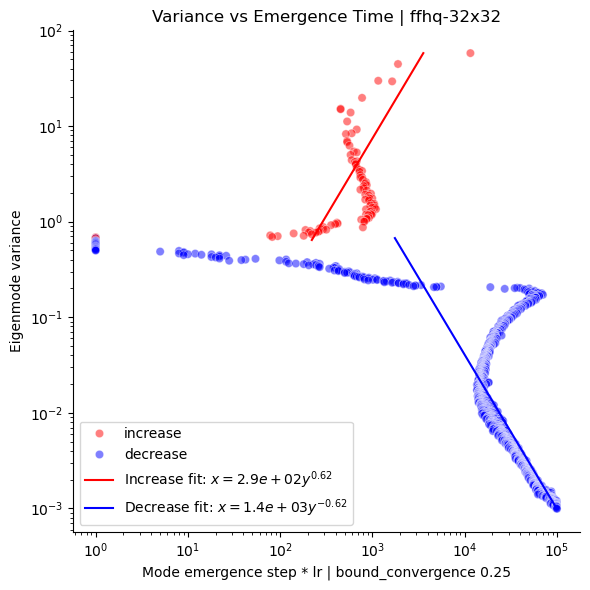

In [15]:
threshold_type = "bound_convergence 0.25"
figh = analyze_and_plot_variance(df_bounded, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), 
                          title=f'Variance vs Emergence Time | {dataset_name}', 
                          xlabel=f'Mode emergence step * lr | {threshold_type}', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)
          

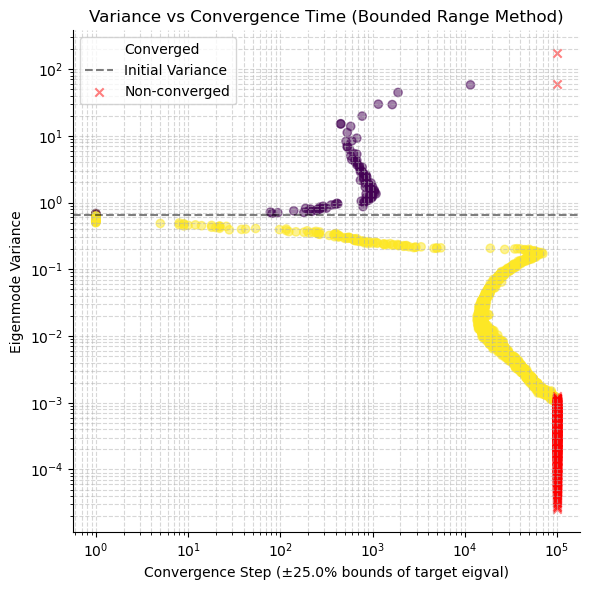

In [5]:
mean_init_var = diag_cov_x_sample_true_eigenbasis_traj[0, :].mean().item()
std_init_var = diag_cov_x_sample_true_eigenbasis_traj[0, :].std().item()
# Plot the results
plt.figure(figsize=(6, 6))
# Plot converged points as dots
converged = df_bounded['convergence_step'].notna()
# plt.scatter(df_bounded.loc[converged, 'convergence_step'], df_bounded.loc[converged, 'Variance'], alpha=0.5, label='Converged')
plt.scatter(df_bounded['convergence_step'], df_bounded['Variance'], c=df_bounded['direction'], alpha=0.5, label='Converged')
plt.axhline(mean_init_var, color='black', linestyle='--', alpha=0.5, label='Initial Variance')
# Plot non-converged points as X markers
non_converged = ~converged
if non_converged.any():
    x_coords = [plt.xlim()[1] * 0.95] * non_converged.sum()
    plt.scatter(
        x_coords,  # Place at right side of plot
        df_bounded.loc[non_converged, 'Variance'], 
        marker='x', color='red', alpha=0.5,
        label='Non-converged'
    )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'Convergence Step (±{fraction*100}% bounds of target eigval)')
plt.ylabel('Eigenmode Variance')
plt.title('Variance vs Convergence Time (Bounded Range Method)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig(f"{figdir}/bounded_convergence_variance_vs_step.png", dpi=300)
plt.show()

In [23]:
diag_cov_x_sample_true_eigenbasis_traj[-10:, 3011]

tensor([0.0004, 0.0004, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0004])

In [34]:
img_eigval[3005]

tensor(7.3032e-05, device='cuda:0')

In [ ]:
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(img_eigval, diag_cov_x_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{figdir}/synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)
saveallforms(figdir, f"synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")

In [ ]:

# patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
#      process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", 
#                                        imgshape=imgshape)
#%%
slice2plot = slice(0, 9, 1)
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, img_eigval.cpu(), slice2plot,
               patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="FFHQ32 MLP")
#%% plot the convergence of the mean 
slice2plot = slice(0, 9, 1)
plot_mean_deviation_trajectories(step_slice, mean_x_sample_traj, img_mean, img_eigvec.cpu(), img_eigval.cpu(), 
               slice2plot, patch_size, patch_stride, savedir=figdir, dataset_name="FFHQ32 MLP") 
#%%
slice2plot = slice(0, 100, 10)
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, img_eigval.cpu(), slice2plot,
               patch_size=patch_size, patch_stride=patch_stride, savedir=figdir, dataset_name="FFHQ32 MLP")
#%%
slice2plot = slice(0, 100, 10)
plot_mean_deviation_trajectories(step_slice, mean_x_sample_traj, img_mean, img_eigvec.cpu(), img_eigval.cpu(), 
               slice2plot, patch_size, patch_stride, savedir=figdir, dataset_name="FFHQ32 MLP") 

#%% plot the mean and PC0 eigenmode
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_mean.reshape(3, 32, 32).permute(1, 2, 0).cpu() * 10 + 0.5)
plt.subplot(1, 2, 2)
plt.imshow(img_eigvec[:, 0].reshape(3, 32, 32).permute(1, 2, 0).cpu() * 10 + 0.5)
plt.show()
#%%%
lr = 1e-4
lr_step_slice = np.array(step_slice) * lr
df = compute_crossing_points(img_eigval, diag_cov_x_sample_true_eigenbasis_traj, lr_step_slice, smooth_sigma=0.1, threshold_type="harmonic_mean", )
df.to_csv(f"{figdir}/synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)
figh = analyze_and_plot_variance(df, x_col='emergence_step', y_col='Variance', 
                          hue_col='Direction', palette={"increase": "red", "decrease": "blue"}, 
                          log_x=True, log_y=True, figsize=(6, 6), fit_label_format='{direction} fit: $x = {a:.1e}y^{{{b:.2f}}}$', 
                          reverse_equation=True, annotate=False, annotate_offset=(0, 0), title=f'Variance vs Emergence Time | patch {patch_size}x{patch_size} stride {patch_stride}', 
                          xlabel='Mode emergence step * lr | harmonic mean', ylabel='Eigenmode variance', alpha=0.5, fit_line_kwargs=None, scatter_kwargs=None, ax=None)
saveallforms(figdir, f"synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse")
